<a href="https://colab.research.google.com/github/sameera-g-mathad/DSC-478/blob/main/DSC_478_Final_Project(Book_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'books-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F912577%2F1546766%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240328%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240328T000246Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7c08497a3c1ccc8bbecf8bdc9ac890c55efdf77fe487f0ec5885cb1fe522803a56051de7358c23a7f2568a7ae8aad059cc34eddbd821810903a40206a9c30f29a3e08bbcfe46d6ae8a0d8b4f242c99ede7e1ce117ab3f149c64098aaf73dc9aacbfb3ab59726fc9d208ceb63f0ae3ea0470551d591295d8c02804b8543b3484426e3a43673d14fbe86a078e96e68b0887dbda5c1c213e0b73ba463f25c6693b25b57195dc504dce05273737c916edbf120f272371ae764fcb8714e5796ff560f972b9417f19bc2d6d091b8ffda34e6ecfdf454684b56f1612cc7759870b22538191555a9259274cea5874a754c0fa762025c9189668426af573b380247c43ae4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import NearestCentroid,NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.utils.extmath import randomized_svd
from IPython.display import display
from numpy import linalg as la
from scipy.sparse import csr_matrix
pd.set_option('display.max_colwidth',None)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/books-dataset/books_data/ratings.csv
/kaggle/input/books-dataset/books_data/users.csv
/kaggle/input/books-dataset/books_data/books.csv


# ------------ Pre-Processing ------------

#### Loading all the Data files

In [ ]:
users_df = pd.read_csv('/kaggle/input/books-dataset/books_data/users.csv',sep=";",on_bad_lines="skip",encoding='latin-1')
ratings_df = pd.read_csv('/kaggle/input/books-dataset/books_data/ratings.csv',sep=";",on_bad_lines="skip",encoding='latin-1')
books_df = pd.read_csv("/kaggle/input/books-dataset/books_data/books.csv",sep=";",on_bad_lines='skip',encoding = 'latin-1',low_memory = False)

#### List down all the loaded files to check the shape and data

In [ ]:
print("Books dataframe shape: " , books_df.shape)
print("Ratings dataframe shape: " , ratings_df.shape)
print("Users dataframe shape: " , users_df.shape)

Books dataframe shape:  (271360, 8)
Ratings dataframe shape:  (1149780, 3)
Users dataframe shape:  (278858, 3)


In [ ]:
books_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [ ]:
ratings_df.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### *********************** PRE-PROCESSING ****************************

#### First we will work on users dataframe

In [ ]:
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


#### From the above result, we can see that location consists of city, state, country
#### So, we will filter out the attribute having data less than 3 values

In [ ]:
# Getting the indices of location which is not equal to 3
drop_indeces = users_df[users_df['Location'].str.split(",").str.len() != 3].index

In [ ]:
## Dropping the above indices
users_df = users_df.drop(index = drop_indeces)


In [ ]:
## Computing the count whose location has all 3 values
(users_df['Location'].str.split(",").str.len()==3).value_counts()

Location
True    277348
Name: count, dtype: int64

#### Splitting location column into City,State and Country columns

In [ ]:
users_df[['City','State','Country']] = users_df['Location'].str.strip().str.split(",",expand = True,n=2)

#### Trimming data to removing leading and tailing spaces

In [ ]:
users_df['City'] = users_df['City'].str.strip()
users_df['State'] = users_df['State'].str.strip()
users_df['Country'] = users_df['Country'].str.strip()

In [ ]:
users_df.head()

,User-ID,Location,Age,City,State,Country
0,1,"nyc, new york, usa",NaN,nyc,new york,usa
1,2,"stockton, california, usa",18.0,stockton,california,usa
2,3,"moscow, yukon territory, russia",NaN,moscow,yukon territory,russia
3,4,"porto, v.n.gaia, portugal",17.0,porto,v.n.gaia,portugal
4,5,"farnborough, hants, united kingdom",NaN,farnborough,hants,united kingdom


#### from the above result, we can see that location's data is split into city state and country

#### Dropping column 'Location' as it is split into (City,State,Country) columns

In [ ]:
users_df = users_df.drop('Location',axis = 1)
users_df

,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom
...,...,...,...,...,...
278853,278854,NaN,portland,oregon,usa
278854,278855,50.0,tacoma,washington,united kingdom
278855,278856,NaN,brampton,ontario,canada
278856,278857,NaN,knoxville,tennessee,usa


In [ ]:
users_df['Age'].unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,   2.,  70.,  77.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

#### From the above result we can see that there are values of age greater than 100 which is not ideal so filtering it out

## Also we are considering age group between 10 to 90 to get more appropriate data

In [ ]:
users_df[~users_df['Age'].between(10,90) & ~users_df['Age'].isnull()]['Age'].unique()

array([  0.,   1.,   9., 103., 104., 231.,   3., 119.,   2.,  93.,   8.,
         7.,   4., 114., 230., 239.,   5., 148., 151.,   6., 101., 201.,
        96., 123., 244., 133.,  91., 128.,  94., 141., 110.,  97., 219.,
       124.,  92., 175., 172., 209., 212., 237., 162., 100., 156., 136.,
        95., 106.,  99., 108., 210., 199., 147., 168., 132., 159., 186.,
       152., 102., 116., 200., 115., 226., 137., 207., 229., 138., 109.,
       105., 228., 183., 204.,  98., 223., 113., 208., 157., 111., 146.,
       118., 220., 143., 140., 189., 127.])

Text(0, 0.5, 'Frequency')

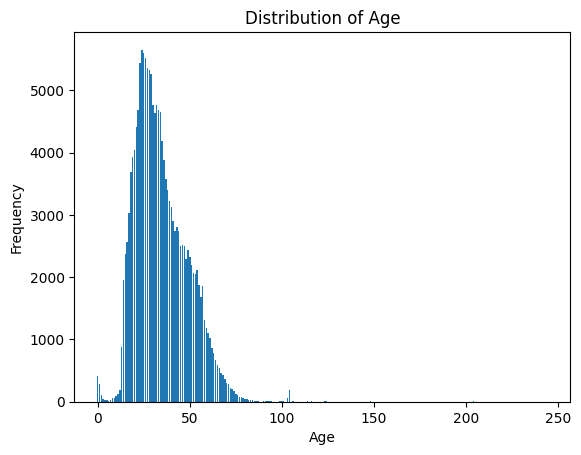

In [ ]:
ages_graph_params = users_df.groupby('Age').size()
plt.bar(ages_graph_params.index,ages_graph_params.values)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

#### Filtering the age group as mentioned

In [ ]:
users_to_omit = ~users_df['Age'].between(10,90) & ~users_df['Age'].isnull()
users_df.loc[users_to_omit] = np.nan
users_df['Age'].sort_values().unique()

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
       49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61.,
       62., 63., 64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74.,
       75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85., 86., 87.,
       88., 89., 90., nan])

#### From the above result, now we can see that age is as expected. Now we can replace the Nan values with its mean

In [ ]:
users_df.head()

,User-ID,Age,City,State,Country
0,1.0,NaN,nyc,new york,usa
1,2.0,18.0,stockton,california,usa
2,3.0,NaN,moscow,yukon territory,russia
3,4.0,17.0,porto,v.n.gaia,portugal
4,5.0,NaN,farnborough,hants,united kingdom


In [ ]:
users_df['Age'].mean()

34.729518290474466

#### Imputing age column with the mean age value of 34

In [ ]:
null_age = users_df['Age'].isnull()
users_df.loc[null_age,'Age'] = users_df['Age'].mean()

<BarContainer object of 82 artists>

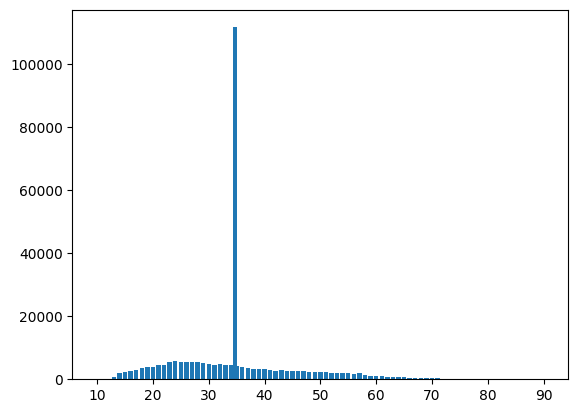

In [ ]:
ages_graph_params = users_df.groupby('Age').size()
plt.bar(ages_graph_params.index,ages_graph_params.values)


In [ ]:
users_df.head()

,User-ID,Age,City,State,Country
0,1.0,34.729518,nyc,new york,usa
1,2.0,18.000000,stockton,california,usa
2,3.0,34.729518,moscow,yukon territory,russia
3,4.0,17.000000,porto,v.n.gaia,portugal
4,5.0,34.729518,farnborough,hants,united kingdom


In [ ]:
users_df['Age'] = users_df['Age'].astype('int')

In [ ]:
users_df['Age'].sort_values().unique()

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90])

#### From the above result now we can say that age attribute is pre-processed correctly

#### Column country has garbage and reduntant values

In [ ]:
users_df['Country'].sort_values().unique()

array(['', '"', '&#20013;&#22269;', '&#32654;&#22269;', '*', '-',
       '-------', '.', '01776', '02458', '19104', '23232', '30064',
       '5057chadwick ct.', '85021', '87510', '?ú?{', '\\"n/a\\""',
       '\\n/a\\""', '_ brasil', 'a', 'aaa', 'adsgfdr',
       'afganstand holla !!', 'afghanistan', 'ahrensburg', 'alachua',
       'albania', 'alderney', 'algeria', 'algérie', 'allen', 'ama lurra',
       'america', 'american samoa', 'andorra', 'andorra"', 'angola',
       'antarctica', 'antigua & barbuda', 'antigua and barbuda',
       'aotearoa', 'argentina', 'argentina"', 'armenia', 'aroostook',
       'aruba', 'asturies', 'auckland', 'australia', 'australia"',
       'australii', 'austria', 'austria"', 'autralia', 'az', 'azerbaijan',
       'bademn würtemberg', 'baden-württemberg', 'bahamas', 'bahrain',
       'baltimore', 'bangladesh', 'bangladesh"', 'barbados', 'basilicata',
       'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus',
       'belgi', 'belgique', 'belgium', 

#### We are using list of countries from this link for filtering out users.

In [ ]:
countries = (
    ('AF', 'AFGHANISTAN'),
    ('AL', 'ALBANIA'),
    ('DZ', 'ALGERIA'),
    ('AS', 'AMERICAN SAMOA'),
    ('AD', 'ANDORRA'),
    ('AO', 'ANGOLA'),
    ('AI', 'ANGUILLA'),
    ('AQ', 'ANTARCTICA'),
    ('AG', 'ANTIGUA AND BARBUDA'),
    ('AR', 'ARGENTINA'),
    ('AM', 'ARMENIA'),
    ('AW', 'ARUBA'),
    ('AU', 'AUSTRALIA'),
    ('AT', 'AUSTRIA'),
    ('AZ', 'AZERBAIJAN'),
    ('BS', 'BAHAMAS'),
    ('BH', 'BAHRAIN'),
    ('BD', 'BANGLADESH'),
    ('BB', 'BARBADOS'),
    ('BY', 'BELARUS'),
    ('BE', 'BELGIUM'),
    ('BZ', 'BELIZE'),
    ('BJ', 'BENIN'),
    ('BM', 'BERMUDA'),
    ('BT', 'BHUTAN'),
    ('BO', 'BOLIVIA'),
    ('BA', 'BOSNIA AND HERZEGOVINA'),
    ('BW', 'BOTSWANA'),
    ('BV', 'BOUVET ISLAND'),
    ('BR', 'BRAZIL'),
    ('IO', 'BRITISH INDIAN OCEAN TERRITORY'),
    ('BN', 'BRUNEI DARUSSALAM'),
    ('BG', 'BULGARIA'),
    ('BF', 'BURKINA FASO'),
    ('BI', 'BURUNDI'),
    ('KH', 'CAMBODIA'),
    ('CM', 'CAMEROON'),
    ('CA', 'CANADA'),
    ('CV', 'CAPE VERDE'),
    ('KY', 'CAYMAN ISLANDS'),
    ('CF', 'CENTRAL AFRICAN REPUBLIC'),
    ('TD', 'CHAD'),
    ('CL', 'CHILE'),
    ('CN', 'CHINA'),
    ('CX', 'CHRISTMAS ISLAND'),
    ('CC', 'COCOS (KEELING) ISLANDS'),
    ('CO', 'COLOMBIA'),
    ('KM', 'COMOROS'),
    ('CG', 'CONGO'),
    ('CD', 'CONGO, THE DEMOCRATIC REPUBLIC OF'),
    ('CK', 'COOK ISLANDS'),
    ('CR', 'COSTA RICA'),
    ('CI', "CÃ”TE D'IVOIRE"),
    ('HR', 'CROATIA'),
    ('CU', 'CUBA'),
    ('CY', 'CYPRUS'),
    ('CZ', 'CZECH REPUBLIC'),
    ('DK', 'DENMARK'),
    ('DJ', 'DJIBOUTI'),
    ('DM', 'DOMINICA'),
    ('DO', 'DOMINICAN REPUBLIC'),
    ('EC', 'ECUADOR'),
    ('EG', 'EGYPT'),
    ('SV', 'EL SALVADOR'),
    ('GQ', 'EQUATORIAL GUINEA'),
    ('ER', 'ERITREA'),
    ('EE', 'ESTONIA'),
    ('ET', 'ETHIOPIA'),
    ('FK', 'FALKLAND ISLANDS (MALVINAS)'),
    ('FO', 'FAROE ISLANDS'),
    ('FJ', 'FIJI'),
    ('FI', 'FINLAND'),
    ('FR', 'FRANCE'),
    ('GF', 'FRENCH GUIANA'),
    ('PF', 'FRENCH POLYNESIA'),
    ('TF', 'FRENCH SOUTHERN TERRITORIES'),
    ('GA', 'GABON'),
    ('GM', 'GAMBIA'),
    ('GE', 'GEORGIA'),
    ('DE', 'GERMANY'),
    ('GH', 'GHANA'),
    ('GI', 'GIBRALTAR'),
    ('GR', 'GREECE'),
    ('GL', 'GREENLAND'),
    ('GD', 'GRENADA'),
    ('GP', 'GUADELOUPE'),
    ('GU', 'GUAM'),
    ('GT', 'GUATEMALA'),
    ('GN', 'GUINEA'),
    ('GW', 'GUINEA'),
    ('GY', 'GUYANA'),
    ('HT', 'HAITI'),
    ('HM', 'HEARD ISLAND AND MCDONALD ISLANDS'),
    ('HN', 'HONDURAS'),
    ('HK', 'HONG KONG'),
    ('HU', 'HUNGARY'),
    ('IS', 'ICELAND'),
    ('IN', 'INDIA'),
    ('ID', 'INDONESIA'),
    ('IR', 'IRAN, ISLAMIC REPUBLIC OF'),
    ('IQ', 'IRAQ'),
    ('IE', 'IRELAND'),
    ('IL', 'ISRAEL'),
    ('IT', 'ITALY'),
    ('JM', 'JAMAICA'),
    ('JP', 'JAPAN'),
    ('JO', 'JORDAN'),
    ('KZ', 'KAZAKHSTAN'),
    ('KE', 'KENYA'),
    ('KI', 'KIRIBATI'),
    ('KP', "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF"),
    ('KR', 'KOREA, REPUBLIC OF'),
    ('KW', 'KUWAIT'),
    ('KG', 'KYRGYZSTAN'),
    ('LA', "LAO PEOPLE'S DEMOCRATIC REPUBLIC"),
    ('LV', 'LATVIA'),
    ('LB', 'LEBANON'),
    ('LS', 'LESOTHO'),
    ('LR', 'LIBERIA'),
    ('LY', 'LIBYAN ARAB JAMAHIRIYA'),
    ('LI', 'LIECHTENSTEIN'),
    ('LT', 'LITHUANIA'),
    ('LU', 'LUXEMBOURG'),
    ('MO', 'MACAO'),
    ('MK', 'MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF'),
    ('MG', 'MADAGASCAR'),
    ('MW', 'MALAWI'),
    ('MY', 'MALAYSIA'),
    ('MV', 'MALDIVES'),
    ('ML', 'MALI'),
    ('MT', 'MALTA'),
    ('MH', 'MARSHALL ISLANDS'),
    ('MQ', 'MARTINIQUE'),
    ('MR', 'MAURITANIA'),
    ('MU', 'MAURITIUS'),
    ('YT', 'MAYOTTE'),
    ('MX', 'MEXICO'),
    ('FM', 'MICRONESIA, FEDERATED STATES OF'),
    ('MD', 'MOLDOVA, REPUBLIC OF'),
    ('MC', 'MONACO'),
    ('MN', 'MONGOLIA'),
    ('MS', 'MONTSERRAT'),
    ('MA', 'MOROCCO'),
    ('MZ', 'MOZAMBIQUE'),
    ('MM', 'MYANMAR'),
    ('NA', 'NAMIBIA'),
    ('NR', 'NAURU'),
    ('NP', 'NEPAL'),
    ('NL', 'NETHERLANDS'),
    ('AN', 'NETHERLANDS ANTILLES'),
    ('NC', 'NEW CALEDONIA'),
    ('NZ', 'NEW ZEALAND'),
    ('NI', 'NICARAGUA'),
    ('NE', 'NIGER'),
    ('NG', 'NIGERIA'),
    ('NU', 'NIUE'),
    ('NF', 'NORFOLK ISLAND'),
    ('MP', 'NORTHERN MARIANA ISLANDS'),
    ('NO', 'NORWAY'),
    ('OM', 'OMAN'),
    ('PK', 'PAKISTAN'),
    ('PW', 'PALAU'),
    ('PS', 'PALESTINIAN TERRITORY, OCCUPIED'),
    ('PA', 'PANAMA'),
    ('PG', 'PAPUA NEW GUINEA'),
    ('PY', 'PARAGUAY'),
    ('PE', 'PERU'),
    ('PH', 'PHILIPPINES'),
    ('PN', 'PITCAIRN'),
    ('PL', 'POLAND'),
    ('PT', 'PORTUGAL'),
    ('PR', 'PUERTO RICO'),
    ('QA', 'QATAR'),
    ('RE', 'RÃ‰UNION'),
    ('RO', 'ROMANIA'),
    ('RU', 'RUSSIAN FEDERATION'),
    ('RW', 'RWANDA'),
    ('SH', 'SAINT HELENA'),
    ('KN', 'SAINT KITTS AND NEVIS'),
    ('LC', 'SAINT LUCIA'),
    ('PM', 'SAINT PIERRE AND MIQUELON'),
    ('VC', 'SAINT VINCENT AND THE GRENADINES'),
    ('WS', 'SAMOA'),
    ('SM', 'SAN MARINO'),
    ('ST', 'SAO TOME AND PRINCIPE'),
    ('SA', 'SAUDI ARABIA'),
    ('SN', 'SENEGAL'),
    ('CS', 'SERBIA AND MONTENEGRO'),
    ('SC', 'SEYCHELLES'),
    ('SL', 'SIERRA LEONE'),
    ('SG', 'SINGAPORE'),
    ('SK', 'SLOVAKIA'),
    ('SI', 'SLOVENIA'),
    ('SB', 'SOLOMON ISLANDS'),
    ('SO', 'SOMALIA'),
    ('ZA', 'SOUTH AFRICA'),
    ('GS', 'SOUTH GEORGIA AND SOUTH SANDWICH ISLANDS'),
    ('ES', 'SPAIN'),
    ('LK', 'SRI LANKA'),
    ('SD', 'SUDAN'),
    ('SR', 'SURINAME'),
    ('SJ', 'SVALBARD AND JAN MAYEN'),
    ('SZ', 'SWAZILAND'),
    ('SE', 'SWEDEN'),
    ('CH', 'SWITZERLAND'),
    ('SY', 'SYRIAN ARAB REPUBLIC'),
    ('TW', 'TAIWAN, PROVINCE OF CHINA'),
    ('TJ', 'TAJIKISTAN'),
    ('TZ', 'TANZANIA, UNITED REPUBLIC OF'),
    ('TH', 'THAILAND'),
    ('TL', 'TIMOR'),
    ('TG', 'TOGO'),
    ('TK', 'TOKELAU'),
    ('TO', 'TONGA'),
    ('TT', 'TRINIDAD AND TOBAGO'),
    ('TN', 'TUNISIA'),
    ('TR', 'TURKEY'),
    ('TM', 'TURKMENISTAN'),
    ('TC', 'TURKS AND CAICOS ISLANDS'),
    ('TV', 'TUVALU'),
    ('UG', 'UGANDA'),
    ('UA', 'UKRAINE'),
    ('AE', 'UNITED ARAB EMIRATES'),
    ('GB', 'UNITED KINGDOM'),
    ('US', 'UNITED STATES'),
    ('UM', 'UNITED STATES MINOR OUTLYING ISLANDS'),
    ('UY', 'URUGUAY'),
    ('UZ', 'UZBEKISTAN'),
    ('VU', 'VANUATU'),
    ('VN', 'VIET NAM'),
    ('VG', 'VIRGIN ISLANDS, BRITISH'),
    ('VI', 'VIRGIN ISLANDS, U.S.'),
    ('WF', 'WALLIS AND FUTUNA'),
    ('EH', 'WESTERN SAHARA'),
    ('YE', 'YEMEN'),
    ('ZW', 'ZIMBABWE')
)

In [ ]:
list_of_countries = []
for i in countries:
    list_of_countries.append(i[1].lower())

In [ ]:
print(list_of_countries)

['afghanistan', 'albania', 'algeria', 'american samoa', 'andorra', 'angola', 'anguilla', 'antarctica', 'antigua and barbuda', 'argentina', 'armenia', 'aruba', 'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bermuda', 'bhutan', 'bolivia', 'bosnia and herzegovina', 'botswana', 'bouvet island', 'brazil', 'british indian ocean territory', 'brunei darussalam', 'bulgaria', 'burkina faso', 'burundi', 'cambodia', 'cameroon', 'canada', 'cape verde', 'cayman islands', 'central african republic', 'chad', 'chile', 'china', 'christmas island', 'cocos (keeling) islands', 'colombia', 'comoros', 'congo', 'congo, the democratic republic of', 'cook islands', 'costa rica', "cã”te d'ivoire", 'croatia', 'cuba', 'cyprus', 'czech republic', 'denmark', 'djibouti', 'dominica', 'dominican republic', 'ecuador', 'egypt', 'el salvador', 'equatorial guinea', 'eritrea', 'estonia', 'ethiopia', 'falkland islands (malvinas)', 'faroe islands

#### Filtering users based on our list_of_countries values

In [ ]:
users_df = users_df[users_df['Country'].isin(list_of_countries)]
users_df

,User-ID,Age,City,State,Country
3,4.0,17,porto,v.n.gaia,portugal
4,5.0,34,farnborough,hants,united kingdom
7,8.0,34,timmins,ontario,canada
9,10.0,26,albacete,wisconsin,spain
10,11.0,14,melbourne,victoria,australia
...,...,...,...,...,...
278851,278852.0,32,brisbane,queensland,australia
278852,278853.0,17,stranraer,n/a,united kingdom
278854,278855.0,50,tacoma,washington,united kingdom
278855,278856.0,34,brampton,ontario,canada


#### Now selecting states and cities with atleast 4 characters and filtering it out with junk characters

In [ ]:
list_of_states = users_df['State'].str.extract(r'(^[a-z]{4}[a-z]*|^[a-z]{1}[a-z]*\w[a-z]{4})')[0].unique()

In [ ]:
users_df = users_df[users_df['State'].isin(list_of_states)]

In [ ]:
list_of_city = users_df['City'].str.extract(r'(^[a-z]{4}[a-z]*|^[a-z]{1}[a-z]*\w[a-z]{4})')[0].unique()
users_df = users_df[users_df['City'].isin(list_of_city)]

In [ ]:
print("Unique country count: " , users_df['Country'].nunique())
print("Unique state count: " ,users_df['State'].nunique())
print("Unique City count: " , users_df['City'].nunique())

Unique country count:  154
Unique state count:  2192
Unique City count:  8452


#### Filtering the books dataset. Removing unrelated attributes

In [ ]:
books_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [ ]:
books_df = books_df.drop(['Image-URL-S','Image-URL-M','Image-URL-L'],axis = 1)
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [ ]:
books_df['Year-Of-Publication'].unique()


array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', 'DK Publishing Inc', 'Gallimard', '1909',
       

#### From the above result, we can see some garbage values in 'Year-Of-Publication' instead of only year values, which will be filtered and the column is converted into int

In [ ]:
year_of_publication = books_df['Year-Of-Publication'].str.extract(r'(\d{4})')[0]
books_df = books_df[books_df['Year-Of-Publication'].isin(year_of_publication)]

In [ ]:
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype('int')

/tmp/ipykernel_33/406188384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype('int')


In [ ]:
books_df['Year-Of-Publication'].unique()


array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030, 1911,
       1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934, 1910,
       1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901, 2010,
       1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378, 1919,
       1922, 1897, 2024, 1376, 2037])

#### Lets Check Ratings Datafram

In [ ]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
sorted(ratings_df['Book-Rating'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Text(0, 0.5, 'Frequency')

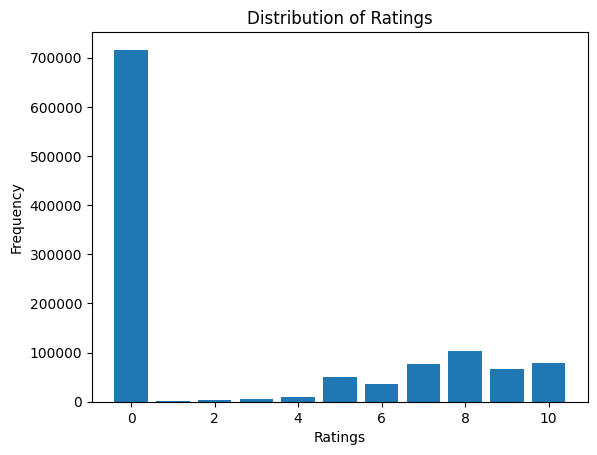

In [ ]:
ratings_group = ratings_df.groupby('Book-Rating').size()
plt.bar(ratings_group.index,ratings_group.values)
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

#### Lets check the info of all 3 data files

In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266739 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 266739 non-null  object
 1   Book-Title           266739 non-null  object
 2   Book-Author          266737 non-null  object
 3   Year-Of-Publication  266739 non-null  int64 
 4   Publisher            266737 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.2+ MB


In [ ]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69301 entries, 4 to 278855
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User-ID  69301 non-null  float64
 1   Age      69301 non-null  int64  
 2   City     69301 non-null  object 
 3   State    69301 non-null  object 
 4   Country  69301 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 3.2+ MB


#### Now preparing the dataset for further implementation

#### Merging Users,Books,Ratings dataframe for our dataset

In [ ]:
dataset = ratings_df.merge(books_df,on = 'ISBN').merge(users_df,how='inner',on='User-ID')
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132920 entries, 0 to 132919
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User-ID              132920 non-null  int64 
 1   ISBN                 132920 non-null  object
 2   Book-Rating          132920 non-null  int64 
 3   Book-Title           132920 non-null  object
 4   Book-Author          132919 non-null  object
 5   Year-Of-Publication  132920 non-null  int64 
 6   Publisher            132920 non-null  object
 7   Age                  132920 non-null  int64 
 8   City                 132920 non-null  object
 9   State                132920 non-null  object
 10  Country              132920 non-null  object
dtypes: int64(4), object(7)
memory usage: 11.2+ MB


#### Dropping the duplicate user-ID and ISBN rows as a user can have only one rating per book.

In [ ]:
dataset = dataset.drop_duplicates(['User-ID','ISBN'],keep='first')
dataset.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,276774,0099543818,0,"East, West",Salman Rushdie,1995,Vintage Books,28,bern,bern,switzerland
1,276774,3404147723,0,Im Schatten der Lilie. Die Erinnerungen der Eleonore von Aquitanien.,Patrice Leavold,2002,LÃ?Â¼bbe,28,bern,bern,switzerland
2,276774,3423111321,0,Die Teufelin. Roman.,Fay Weldon,1989,Dtv,28,bern,bern,switzerland
3,276774,3442136644,9,Endlich Nichtraucher.,Allen Carr,1992,Goldmann,28,bern,bern,switzerland
4,276774,3492232000,0,Ein Liebhaber zuviel ist noch zu wenig.,Gaby Hauptmann,2000,Piper,28,bern,bern,switzerland


In [ ]:
dataset[['Book-Rating','Book-Author','Year-Of-Publication','Publisher','Age','City','State','Country']].sample(10)

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
35338,0,Julia London,2001,Dell Publishing Company,34,melaka,melaka,malaysia
39496,0,Marlene Streeruwitz,2002,"Fischer (Tb.), Frankfurt",40,berlin,berlin,germany
66197,0,Nevada Barr,1999,Avon,34,london,england,united kingdom
73680,9,Di Morrissey,1998,HarperCollins Publishers,48,deventer,overijssel,netherlands
46220,0,Douglas Preston,2002,Warner Books,34,toronto,ontario,canada
5329,0,Patricia Waddell,2002,Love Spell,15,doha,doha,qatar
33963,4,Kathy Lette,1995,McClelland &amp; Stewart Ltd,38,london,england,united kingdom
38854,0,A. E. Maxwell,1994,Harper Mass Market Paperbacks (Mm),34,firenze,toscana,italy
67122,0,Jerry Hopkins,1972,Warner Books,34,edmonton,alberta,canada
32780,5,John Grisham,1994,Dell Publishing Company,34,latina,latina,italy


#### Selecting the required columns for training

In [ ]:
recomendation_dataset = dataset[['Book-Rating','Book-Author','Year-Of-Publication','Publisher','Age','City','State','Country']].copy()
recomendation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132920 entries, 0 to 132919
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Book-Rating          132920 non-null  int64 
 1   Book-Author          132919 non-null  object
 2   Year-Of-Publication  132920 non-null  int64 
 3   Publisher            132920 non-null  object
 4   Age                  132920 non-null  int64 
 5   City                 132920 non-null  object
 6   State                132920 non-null  object
 7   Country              132920 non-null  object
dtypes: int64(3), object(5)
memory usage: 8.1+ MB


#### Label encoding all catecorical columns

In [ ]:
encoder = LabelEncoder()
for column in recomendation_dataset.columns:
    if recomendation_dataset[column].dtype == object:
        recomendation_dataset[column] = encoder.fit_transform(recomendation_dataset[column])


In [ ]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,0,27839,1995,6288,28,261,81,79
1,0,23900,2002,3634,28,261,81,79
2,0,9455,1989,1697,28,261,81,79
3,9,1009,1992,2420,28,261,81,79
4,0,10235,2000,4671,28,261,81,79
...,...,...,...,...,...,...,...,...
132915,0,21284,1997,3025,30,2545,496,16
132916,0,15027,2000,1328,30,2545,496,16
132917,5,15481,1999,5995,34,1830,264,87
132918,5,21118,2000,5995,34,1830,264,87


#### Normalizing every column to range between 0 and 1

In [ ]:
def normalizer(data,min,max):
    return (data - min) / (max - min)

In [ ]:
for column in recomendation_dataset.columns:
    min = recomendation_dataset[column].min()
    max = recomendation_dataset[column].max()
    recomendation_dataset[column] = recomendation_dataset[column].apply(normalizer,args=(min,max))


In [ ]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,0.0,0.857086,0.628378,0.940332,0.225,0.089722,0.107001,0.868132
1,0.0,0.735815,0.675676,0.543443,0.225,0.089722,0.107001,0.868132
2,0.0,0.291093,0.587838,0.253776,0.225,0.089722,0.107001,0.868132
3,0.9,0.031064,0.608108,0.361896,0.225,0.089722,0.107001,0.868132
4,0.0,0.315107,0.662162,0.698520,0.225,0.089722,0.107001,0.868132
...,...,...,...,...,...,...,...,...
132915,0.0,0.655275,0.641892,0.452370,0.250,0.874871,0.655218,0.175824
132916,0.0,0.462640,0.662162,0.198594,0.250,0.874871,0.655218,0.175824
132917,0.5,0.476617,0.655405,0.896516,0.300,0.629082,0.348745,0.956044
132918,0.5,0.650165,0.662162,0.896516,0.300,0.629082,0.348745,0.956044


#### KMeans

#### Running KMeans for finding better k value for clustering

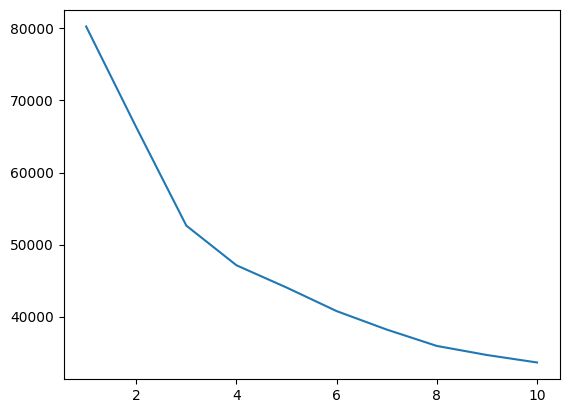

In [ ]:
inertias = []
for i in range(1,11):
    km = KMeans(n_clusters = i,n_init = 'auto')
    km.fit(recomendation_dataset)
    inertias.append(km.inertia_)
plt.plot(range(1,11),inertias)


#### Training on the k value from the above elbow method

In [ ]:
kmeans = KMeans(n_clusters= 5,n_init = 'auto')
clusters = kmeans.fit_predict(recomendation_dataset)


#### Appending cluster values back to our training dataset

In [ ]:
recomendation_dataset['Clusters'] = clusters

In [ ]:
recomendation_dataset['Clusters'].value_counts()

Clusters
2    40247
1    38561
3    25075
0    14588
4    14449
Name: count, dtype: int64

In [ ]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country,Clusters
0,0.0,0.857086,0.628378,0.940332,0.225,0.089722,0.107001,0.868132,1
1,0.0,0.735815,0.675676,0.543443,0.225,0.089722,0.107001,0.868132,1
2,0.0,0.291093,0.587838,0.253776,0.225,0.089722,0.107001,0.868132,1
3,0.9,0.031064,0.608108,0.361896,0.225,0.089722,0.107001,0.868132,3
4,0.0,0.315107,0.662162,0.698520,0.225,0.089722,0.107001,0.868132,1
...,...,...,...,...,...,...,...,...,...
132915,0.0,0.655275,0.641892,0.452370,0.250,0.874871,0.655218,0.175824,2
132916,0.0,0.462640,0.662162,0.198594,0.250,0.874871,0.655218,0.175824,2
132917,0.5,0.476617,0.655405,0.896516,0.300,0.629082,0.348745,0.956044,3
132918,0.5,0.650165,0.662162,0.896516,0.300,0.629082,0.348745,0.956044,3


#### Selecting training and test data

In [ ]:
train_df,test_df = recomendation_dataset.iloc[:,:-1],recomendation_dataset.iloc[:,-1]

#### Splitting training and testing dataset

In [ ]:
train_X,test_x,train_y,test_y = train_test_split(train_df,test_df,test_size=0.2)

#### ROCCHIO CLASSIFIER

#### Creating an instance of Rocchio classifier

In [ ]:
rocchio_clf = NearestCentroid()
rocchio_clf.fit(train_X,train_y)

NearestCentroid()

#### Checking the correctness and accuracy of rocchio method using cross validation

In [ ]:
print(cross_val_score(rocchio_clf,train_df,test_df,cv = 5))

[0.99653927 0.99823202 0.99747969 0.99680259 0.99687782]


#### Predicting results

In [ ]:
pred_y = rocchio_clf.predict(test_x)

In [ ]:
accuracy_score(test_y,pred_y) * 100

99.90219681011135

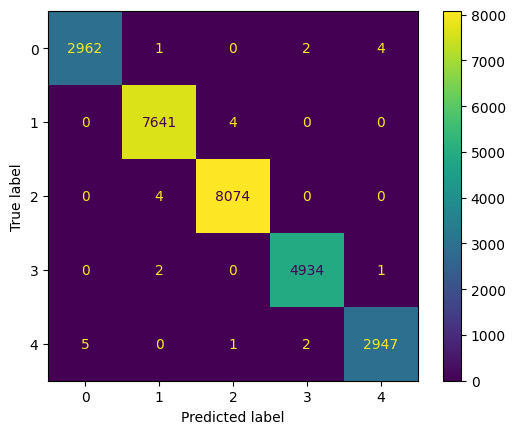

In [ ]:
cm = confusion_matrix(test_y,pred_y)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

#### Taking some samples for recomendation

In [ ]:
samples = test_x.sample(10)
samples

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
110209,0.6,0.485484,0.567568,0.227157,0.5500,0.874871,0.655218,0.175824
88556,0.0,0.139435,0.635135,0.394497,0.3000,0.340323,0.376486,0.351648
53408,0.0,0.491826,0.689189,0.026469,0.1875,0.566518,0.931308,0.054945
53762,0.8,0.092823,0.668919,0.766412,0.4125,0.970093,0.655218,0.175824
14772,0.0,0.485422,0.689189,0.096755,0.3000,0.155036,0.019815,0.175824
499,0.0,0.370832,0.655405,0.253776,0.3375,0.963218,0.968296,0.065934
15269,0.0,0.800622,0.689189,0.892627,0.1000,0.063596,0.175694,0.835165
62711,0.0,0.508543,0.614865,0.247944,0.2375,0.449639,0.655218,0.175824
66194,0.0,0.708106,0.675676,0.397189,0.3000,0.525610,0.261559,0.956044
73751,0.0,0.346603,0.641892,0.816958,0.4750,0.240976,0.669749,0.615385


In [ ]:
indeces = samples.index.tolist()
indeces

[110209, 88556, 53408, 53762, 14772, 499, 15269, 62711, 66194, 73751]

#### Predicting cluster values for our sample values

In [ ]:
samples_pred = rocchio_clf.predict(samples).reshape(1,-1).flatten().tolist()
samples_pred

[0, 1, 2, 0, 1, 2, 1, 2, 1, 1]

In [ ]:
data = train_X.copy()

In [ ]:
data['Clusters'] = train_y

In [ ]:
data

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country,Clusters
35840,0.9,0.529971,0.621622,0.818902,0.3375,0.566518,0.931308,0.054945,4
44784,0.8,0.672424,0.675676,0.438911,0.3000,0.971124,0.517834,0.175824,4
37271,0.0,0.020443,0.648649,0.686406,0.2750,0.517360,0.475561,0.747253,1
108995,0.1,0.419907,0.641892,0.954240,0.3000,0.499484,0.018494,0.725275,1
107828,0.0,0.825190,0.662162,0.898759,0.2875,0.643176,0.261559,0.956044,1
...,...,...,...,...,...,...,...,...,...
98158,0.7,0.006588,0.675676,0.743682,0.3625,0.143004,0.655218,0.175824,0
115639,0.8,0.435639,0.675676,0.240167,0.2750,0.624613,0.767503,0.351648,0
114455,0.8,0.793879,0.608108,0.940631,0.3125,0.874871,0.655218,0.175824,4
100595,0.6,0.050614,0.641892,0.940182,0.3625,0.629426,0.931308,0.054945,0


In [ ]:
samples

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
110209,0.6,0.485484,0.567568,0.227157,0.5500,0.874871,0.655218,0.175824
88556,0.0,0.139435,0.635135,0.394497,0.3000,0.340323,0.376486,0.351648
53408,0.0,0.491826,0.689189,0.026469,0.1875,0.566518,0.931308,0.054945
53762,0.8,0.092823,0.668919,0.766412,0.4125,0.970093,0.655218,0.175824
14772,0.0,0.485422,0.689189,0.096755,0.3000,0.155036,0.019815,0.175824
499,0.0,0.370832,0.655405,0.253776,0.3375,0.963218,0.968296,0.065934
15269,0.0,0.800622,0.689189,0.892627,0.1000,0.063596,0.175694,0.835165
62711,0.0,0.508543,0.614865,0.247944,0.2375,0.449639,0.655218,0.175824
66194,0.0,0.708106,0.675676,0.397189,0.3000,0.525610,0.261559,0.956044
73751,0.0,0.346603,0.641892,0.816958,0.4750,0.240976,0.669749,0.615385


#### Grouping books for recommending books on popular and highest average rating basis

In [ ]:
books_rate_df = dataset.groupby('Book-Title')

#### Filtering popular books

In [ ]:
def popular_books():
    return books_rate_df.size().sort_values(ascending=False).head(10).index

In [ ]:
print('------- Here are some of the popular books you may like -------')
print('-----Happy Reading!!!-------')
pd.Series(popular_books())


------- Here are some of the popular books you may like -------
-----Happy Reading!!!-------


0                                Wild Animus
1                  The Lovely Bones: A Novel
2                      Bridget Jones's Diary
3                                 Life of Pi
4                                   Chocolat
5    The Girls' Guide to Hunting and Fishing
6                          The Da Vinci Code
7                                About a Boy
8                          The Joy Luck Club
9                     Snow Falling on Cedars
Name: Book-Title, dtype: object

#### Filtering books on highest average ratings

In [ ]:
def highest_rated_books():
    return books_rate_df['Book-Rating'].mean().sort_values(ascending=False).head(10).index

In [ ]:
print('------- Here are some of the highest rated books you may like -------')
print('-----Happy Reading!!!-------')
pd.Series(highest_rated_books())


------- Here are some of the highest rated books you may like -------
-----Happy Reading!!!-------


0                                                                                             Pastoral Americana
1               Mercer Mayer's LC + The Critter Kids:  Showdown at the Arcade (A Golden Book School Time Reader)
2                                                                                 McEnroe: A Rage for Perfection
3                                                                                      McKnight in Shining Armor
4                                                              Doktorspiele. GestÃ?Â¤ndnisse eines Hochstaplers.
5                                                                                                           Goya
6                                                                     Bob Saves the Porcupines (Bob The Builder)
7                                                                                       Alistair Cooke's America
8    Seasons for Celebration: A Contemporary Guide to the Joys, Practices, and Traditions of the

# ------------ User based Recommendation ------------

#### Using KNN classifier on the predicted values of rocchio on our sample data for recommendation.¶

In [ ]:
for i in range(len(indeces)):
    knn_dataset = data[data['Clusters']==samples_pred[i]]
    knn_dataset = knn_dataset.reset_index()
    knn = NearestNeighbors()
    knn.fit(knn_dataset.iloc[:,1:-1])
    neighbors = knn.kneighbors(pd.DataFrame(samples.loc[indeces[i]]).T,5,return_distance = False)
    print("\n------------Your Review-------------\n")
    display(pd.DataFrame(dataset.loc[indeces[i],'ISBN':]).T)
    print(f"\n------------Here are few recomendations based on your review that you may like-------------\n")
    recomendations = pd.DataFrame(columns = dataset.columns)

    for j in neighbors:
        display(pd.DataFrame(dataset.loc[knn_dataset.loc[j]['index'],['Book-Title','Book-Author','Year-Of-Publication','Publisher','City','State','Country']]))
    print("\n------------End-------------\n")



------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
110209,0440118700,6,Cry for the Strangers,John Saul,1986,Dell,54,toronto,ontario,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
110213,When the Wind Blows,John Saul,1990,Dell,toronto,ontario,canada
110208,Comes the Blind Fury,John Saul,1990,Dell,toronto,ontario,canada
95843,Crocodile Soup,Julia Darling,2000,Ecco Press,toronto,ontario,canada
51846,The Pelican Brief,John Grisham,1993,Dell,toronto,ontario,canada
109460,The Client,John Grisham,1994,Dell Publishing Company,toronto,ontario,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
88556,0373034261,0,"Something Old, Something New (Hitched) (Harlequin Romance, No 3426)",Catherine Leigh,1996,Harlequin,34,ginsheim,hessen,germany



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
88770,"Christmas Kiss (Eyewitness) (Harlequin Intrigue, No 399)",Caroline Burnes,1996,Harlequin,ginsheim,hessen,germany
88947,"Lord Sin (Harlequin Historical, No 979)",Catherine Archer,1997,Harlequin,ginsheim,hessen,germany
88430,Baby on the Doorstep,Cassie Edwards,1997,HarperTorch,ginsheim,hessen,germany
90043,"Accidental Roommates (Harlequin Love &amp; Laughter, No 4029)",Charlotte Maclay,1997,Harlequin,ginsheim,hessen,germany
90045,"Too Sexy For Marriage (Marriage Makers) (Harlequin Love &amp; Laughter, No 39)",Cathie Linz,1998,Harlequin,ginsheim,hessen,germany



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
53408,1741141680,0,The Cockroach War,Jonathan Harlen,2004,"Allen &amp; Unwin Pty., Limited (Australia)",25,melbourne,victoria,australia



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
46872,Please Stop Laughing at Me: One Woman's Inspirational Story,Jodee Blanco,2003,Adams Media Corporation,melbourne,victoria,australia
118463,"Affair Most Wicked, An",Julianne MacLean,2004,Avon,melbourne,victoria,australia
118462,To Marry the Duke,Julianne MacLean,2003,Avon,melbourne,victoria,australia
118548,The Indiscretion,Judith Ivory,2001,Avon,melbourne,victoria,australia
78126,A Certain Smile,Judith Michael,2000,Ballantine Books,melbourne,victoria,australia



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
53762,1573228575,8,The Forest for the Trees: An Editor's Advice to Writers,Betsy Lerner,2001,Riverhead Books,43,windsor,ontario,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
76990,The Mammy,Brendan O'Carroll,1999,Plume Books,waterdown,ontario,canada
319,Trash,Amy Yamada,1996,Penguin USA,waterloo,ontario,canada
80286,The Illusion of Orderly Progress,Barbara P. Norfleet,1999,Random House Inc,toronto,ontario,canada
7188,Death from the Woods,Brigitte Aubert,2001,Prime Crime,waterloo,ontario,canada
7176,Killing Critics (Kathleen Mallory Novels (Hardcover)),Carol O'Connell,1996,Putnam Publishing Group,waterloo,ontario,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
14772,0425179885,0,The Devil's Code,John Sandford,2004,Berkley Publishing Group,34,calgary,alberta,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
124062,Easy Prey,John Sandford,2001,Berkley Publishing Group,calgary,alberta,canada
79542,Bannerman's Promise,John R. Maxim,2001,Avon,calgary,alberta,canada
26353,The Night Crew,John Sandford,2004,Berkley Publishing Group,calgary,alberta,canada
26410,Nightshade,John Saul,2001,Ballantine Books,calgary,alberta,canada
43910,The Genesis Code,John Case,1998,Ballantine Books,calgary,alberta,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
499,3423202327,0,MÃ?Â¶rder ohne Gesicht.,Henning Mankell,1999,Dtv,37,wien,wien,austria



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
58681,Der Steppenwolf,Hermann Hesse,2004,Distribooks Int'l+inc,wien,wien,austria
63247,Das Superwieb,Hera Lind,2002,Distribooks Inc,wien,wien,austria
117844,Mondgeschichten,Helmut Zenker,2003,Deuticke,wien,wien,austria
117845,Leicht muss man sein. Roman vom Lieben und Verlassen werden.,Heide Pils,2003,"Deuticke, Verlagsgesellschaft Franz",wien,wien,austria
35924,Die Verbrechen der Charlotte Bronte und das Geheimnis von Haworth.,James Tully,2003,Dtv,wien,wien,austria



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
15269,0971880107,0,Wild Animus,Rich Shapero,2004,Too Far,18,barcelona,catalonia,spain



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
1254,Feng Shui: A Complete Guide (Complete Guides),Richard Craze,1997,Trafalgar Square Publishing,barcelona,catalunya,spain
151,Wild Animus,Rich Shapero,2004,Too Far,barcelona,barcelona,spain
57764,Wild Animus,Rich Shapero,2004,Too Far,barcelona,catalunya,spain
56762,Wild Animus,Rich Shapero,2004,Too Far,braga,braga,portugal
56761,Scouting for Boys: A Handbook for Instruction in Good Citizenship,Robert Baden-Powell,1992,Stevens Publishing,braga,braga,portugal



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
62711,1568650698,0,Avaryan Rising,Judith Tarr,1993,Doubleday Books,29,kanata,ontario,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
14543,The Client,John Grisham,1993,Doubleday Books,kingsville,ontario,canada
17198,The Client,John Grisham,1993,Doubleday Books,kingsville,ontario,canada
17199,The Rainmaker,John Grisham,1995,Doubleday Books,kingsville,ontario,canada
14542,The Firm,John Grisham,1991,Doubleday Books,kingsville,ontario,canada
17197,The Firm,John Grisham,1991,Doubleday Books,kingsville,ontario,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
66194,038072362X,0,A Superior Death,Nevada Barr,2002,Harper Mass Market Paperbacks,34,london,england,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
108792,Coraline,Neil Gaiman,2002,HarperCollins,london,england,united kingdom
66084,Eucalyptus: A Novel,Murray Bail,1999,Harvest Books,london,england,united kingdom
66085,The Crimson Petal and the White,Michel Faber,2003,Harvest Books,london,england,united kingdom
8663,The Treason of the Ghosts,Paul Doherty,2001,Headline,london,england,united kingdom
11087,The New York Trilogy,Paul Auster,2003,Green Integer Books,london,england,united kingdom



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
73751,0451188500,0,The Dark Backward,Gregory Hall,1997,Signet Book,48,deventer,overijssel,netherlands



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
73758,No Second Chance,Harlan Coben,2004,Signet Book,deventer,overijssel,netherlands
73753,The Most Wanted,Jacquelyn Mitchard,1999,Signet Book,deventer,overijssel,netherlands
129746,Rosemary's Baby,Ira Levin,1997,Signet Book,deventer,overijssel,netherlands
129800,Enid Blyton (Pocket Biographies),George Greenfield,1998,Sutton Publishing,deventer,overijssel,netherlands
73697,Always in Our Hearts,Doug Most,2000,St. Martin's True Crime Classics,deventer,overijssel,netherlands



------------End-------------



# ------------ Colab Filtering------------

#### Recommender System on Age based

### Filtering the 'Age' Attribute

In [ ]:
age_recommend_dataset = dataset[['Book-Title','Age']].copy()

#### Categorizing it in 3 groups(young, mid-age and old)

In [ ]:
def categorize_age(age):
    if(age>=10 and age <=30):
        return 'young'
    elif age>30 and age<=60:
        return "mid-age"
    else: return "old"

In [ ]:
age_recommend_dataset['Age-Group'] = age_recommend_dataset['Age'].apply(categorize_age)
age_recommend_dataset

,Book-Title,Age,Age-Group
0,"East, West",28,young
1,Im Schatten der Lilie. Die Erinnerungen der Eleonore von Aquitanien.,28,young
2,Die Teufelin. Roman.,28,young
3,Endlich Nichtraucher.,28,young
4,Ein Liebhaber zuviel ist noch zu wenig.,28,young
...,...,...,...
132915,Dying for Veronica: A Sub-Catholic Dream With Mind-Music : A Novel,30,young
132916,The Textbook of the Rose: A Tale,30,young
132917,The Testament,34,mid-age
132918,Dry Rot And Daffodils/Ne,34,mid-age


#### From the above o/p we can see age and its category is displayed

In [ ]:
## Created a function which takes the age and recommends books from the data set as per the age-group

def age_based_recomendation(age,group):
    age_data = age_recommend_dataset[age_recommend_dataset['Age-Group'] == group]
    age_data = age_data.reset_index()
    result = []
    for i in range(age_data.shape[0]):
        #column 2 = Age column
        diff = abs(age_data.iloc[i,2] - age)
        result.append([age_data.iloc[i,0],diff])
    result.sort(key = lambda x: x[1])
    age_data = []
    for i in range(10):
        age_data.append(result[i][0])
    return age_data


#### Lets apply the above function

In [ ]:
age = 26
# Uncomment below line to enter age of you convinient
# age = int(input('Enter you age'))
if(age<=30):
    age_data = age_based_recomendation(age,'young')
elif(age>=30 and age<=60):
    age_data = age_based_recomendation(age,'mid-age')
else:
    age_data = age_based_recomendation(age,'old')
print("-------Here are some books people of your age are reading along------")
display(dataset.iloc[age_data]['Book-Title'])

-------Here are some books people of your age are reading along------


193     The Hissing of the Silent Lonely Room: The Fifth Detective Inspector Christy Kennedy Mystery (Christy Kennedy Mystery)
301                                                                                                El Principito/Little Prince
307                                                                                                            How to be good.
308                                                                                                            Die PrÃ?Â¼fung.
309                                                                                                           MilitÃ?Â¤rmusik.
565                                                              New Vegetarian: Bold and Beautiful Recipes for Every Occasion
742                                                                                                    PRIME TIME : PRIME TIME
1605                                                                                                           

### Collaborative Filtering

#### Item-Based Filtering using KNN

In [ ]:
# lets check ratings dataframe
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
# lets check the number of books each user rated:
ratings_df['User-ID'].value_counts()

User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: count, Length: 105283, dtype: int64

#### from the above output, we could see that there are users who have rated just 1 book
#### We can remove these users or filter out the users who have rated more than 200 books to get substantial amount of rating data, thereby enhancing the reliability of the recommendations.

In [ ]:
x=ratings_df['User-ID'].value_counts() > 200
x[x].shape

(899,)

In [ ]:
y=x[x].index
y

Index([ 11676, 198711, 153662,  98391,  35859, 212898, 278418,  76352, 110973,
       235105,
       ...
       260183,  73681,  44296, 155916,   9856, 274808,  28634,  59727, 268622,
       188951],
      dtype='int64', name='User-ID', length=899)

#### By using index, we can filter out the users

In [ ]:
ratings_knn=ratings_df[ratings_df['User-ID'].isin(y)]
ratings_knn.head(5)

,User-ID,ISBN,Book-Rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


#### lets get the rating of each books in a single df

#### we can mrge books and ratings on ISBN to get ratings of each books against it

In [ ]:
ratings_with_name = ratings_knn.merge(books_df,on='ISBN')
ratings_with_name.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995,John Wiley &amp; Sons
2,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974,Thomson Learning
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau,1982,Henry Holt &amp; Co
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002,Avon Books


In [ ]:
ratings_with_name['Book-Title'].unique().shape

(158319,)

#### Lets compute the total ratings of each book

In [ ]:
# lets compute the ratings of each book

num_rating_df = ratings_with_name.groupby('Book-Title')['Book-Rating'].count().reset_index()
print(num_rating_df.shape)
num_rating_df.head()

(158319, 2)


,Book-Title,Book-Rating
0,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance for the 1990s,1
4,Clifford Visita El Hospital (Clifford El Gran Perro Colorado),1


In [ ]:
# Renaming the column as num_of_ratings

num_rating_df.rename(columns={'Book-Rating': 'num_of_ratings'},inplace=True)
num_rating_df.head()

,Book-Title,num_of_ratings
0,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance for the 1990s,1
4,Clifford Visita El Hospital (Clifford El Gran Perro Colorado),1


#### Lets filter out books with ratings greater than 50, coz the one with number of ratings as '1' wont give us sufficient info

In [ ]:
final_rating = ratings_with_name.merge(num_rating_df,on='Book-Title')
#final_rating.rename(columns={'Book-Rating_y':'num_of_rating'},inplace=True)
final_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,num_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995,John Wiley &amp; Sons,7
2,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974,Thomson Learning,1
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau,1982,Henry Holt &amp; Co,1
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002,Avon Books,13


In [ ]:
final_rating=final_rating[final_rating['num_of_ratings']>=50]
final_rating.head(5)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,num_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
13,277427,0060930535,0,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,133
15,277427,0060934417,0,Bel Canto: A Novel,Ann Patchett,2002,Perennial,108
18,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Paperback)),Janet Evanovich,1995,HarperTorch,108
24,277427,006440188X,0,The Secret Garden,Frances Hodgson Burnett,1998,HarperTrophy,77


#### Dropping duplicate values of user-id and title

In [ ]:
final_rating.drop_duplicates(['User-ID','Book-Title'], inplace=True)

In [ ]:
final_rating.shape

(59507, 8)

#### Now creating the pivot table to use it in further implementation

In [ ]:
book_pivot = final_rating.pivot_table(columns='User-ID',index='Book-Title', values='Book-Rating')

In [ ]:
book_pivot

User-ID,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,0.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


#### From the above table, we can see there are Nan values so lets fill it with '0'

In [ ]:
#lets fill nan with '0'

book_pivot.fillna(0, inplace=True)
book_pivot

User-ID,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
book_sparse =csr_matrix(book_pivot)

#### ************* Implementing the KNN *********************

In [ ]:
from sklearn.neighbors import NearestNeighbors
model=NearestNeighbors(algorithm='brute')


In [ ]:
model.fit(book_sparse)

NearestNeighbors(algorithm='brute')

In [ ]:
book_pivot.iloc[233,:].name

'Harry Potter and the Chamber of Secrets (Book 2)'

In [ ]:

distance,suggestion = model.kneighbors(book_pivot.iloc[233,:].values.reshape(1,-1), n_neighbors=10)

In [ ]:
distance

array([[ 0.        , 67.75691847, 68.05145112, 72.277244  , 75.81556568,
        76.30203143, 76.62245102, 76.64202503, 76.75285011, 76.81796665]])

In [ ]:
suggestion

array([[233, 234, 236, 237, 180, 531, 681, 670, 684, 686]])

In [ ]:
# we need book names
for i in range(len(suggestion)):
    print(book_pivot.index[suggestion[i]])

Index(['Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Sorcerer's Stone (Book 1)', 'Exclusive',
       'The Cradle Will Fall',
       'Tom Clancy's Op-Center (Tom Clancy's Op Center (Paperback))',
       'The Witness', 'Toxin', 'Truly, Madly Manhattan'],
      dtype='object', name='Book-Title')


#### From the above o/p, we can say that if user has read Harry potter book then system has recommended user all books related to harry potter

#### Lets write a function which takes book-id and recommends nearest books

In [ ]:
def recommend_book(book_name):
    book_id=np.where(book_pivot.index == book_name)[0][0]
    distance,suggestion = model.kneighbors(book_pivot.iloc[book_id,:].values.reshape(1,-1), n_neighbors=10)

    for i in range(len(suggestion)):
        books = book_pivot.index[suggestion[i]]
        print("BELOW ARE THE RECOMMENDED BOOKS:  \n")
        for j in books:
            print(j)



In [ ]:
## Taking the book name
book_name= 'Harry Potter and the Chamber of Secrets (Book 2)'
recommend_book(book_name)

BELOW ARE THE RECOMMENDED BOOKS:  

Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Sorcerer's Stone (Book 1)
Exclusive
The Cradle Will Fall
Tom Clancy's Op-Center (Tom Clancy's Op Center (Paperback))
The Witness
Toxin
Truly, Madly Manhattan


#### This is the output of ITEM BASED SYSTEM

#### ************** SVD ***************

#### Creation of Distance and SVD Functions:

In [ ]:
def euclidSim(inA,inB):
    return 1.0/(1.0 + np.linalg.norm(inA - inB))

def pearsonSim(inA,inB):
    if len(inA) < 3 : return 1.0
    return 0.5+0.5*np.corrcoef(inA, inB, rowvar = 0)[0][1]

def svdEst(dataMat, user, simMeas, item):
    n = np.shape(dataMat)[1]
    simTotal = 0.0; ratSimTotal = 0.0
    data=np.mat(dataMat)
    U,Sigma,VT = np.linalg.svd(data)
    Sig4 = np.mat(np.eye(4)*Sigma[:4]) #arrange Sig4 into a diagonal matrix
    xformedItems = data.T * U[:,:4] * Sig4.I  #create transformed items
    for j in range(n):
        userRating = data[user,j]
        if userRating == 0 or j==item: continue
        similarity = simMeas(xformedItems[item,:].T, xformedItems[j,:].T)
        #print('the %d and %d similarity is: %f' % (item, j, similarity))
        simTotal += similarity
        ratSimTotal += similarity * userRating
    if simTotal == 0: return 0
    else: return ratSimTotal/simTotal

#### Creation of recommend function:

#### Developed the ‘recommend’ function to generate book recommendations for a specific user by taking below parameter

In [ ]:
def recommend(dataMat, user, N=3, simMeas = pearsonSim, estMethod=svdEst):
    unratedItems = np.nonzero(dataMat[user,:].A==0)[1] #find unrated items
    if len(unratedItems) == 0: return 'you rated everything'
    itemScores = []
    for item in unratedItems:
        estimatedScore = estMethod(dataMat, user, simMeas, item)
        itemScores.append((item, estimatedScore))
    return sorted(itemScores, key=lambda jj: jj[1], reverse=True)[:N]

In [ ]:
data=np.mat(book_pivot.T)

#### Calling the function to get the recommendations to particular user

In [ ]:
user = 18
recommendations = recommend(data, user, N=5, simMeas=pearsonSim, estMethod=svdEst)
print(recommendations)


[(647, 9.18069315841379), (671, 9.180374101371342), (305, 9.179965684014885), (649, 9.179637398322972), (146, 9.179628020155505)]


#### Implemented a loop to iterate over the recommendations generated by the recommed function.

In [ ]:
print("Recommended Items for User", user, ":\n")
for i, p in recommendations:
    print(f'Book: "{book_pivot.index[i].title()}" , Rating : "{round(p,2)}"')

Recommended Items for User 18 :

Book: "The Summerhouse" , Rating : "9.18"
Book: "The Woman Next Door" , Rating : "9.18"
Book: "Last Chance Saloon" , Rating : "9.18"
Book: "The Surgeon" , Rating : "9.18"
Book: "Deception Point" , Rating : "9.18"
